<span style="background-color:rgb(255, 100, 100)">If you encounter an error, re-run the cells from the beginning. This is due to some numerical issues that aren't handled to carefully.</span>.
# A Tutorial on Vanilla Bayesian Optimization
Bayesian optimization (BO) is often employed to find the optimum of an expensive-to-evaluate "black-box" function $f(x)$. BO can be compactly described in few steps:
1. Run some initial experiments to gather data
2. Initialize the surrogate model
3. Construct the acquisition function
4. Optimize the acquisition function
5. Sample new data at location based on optimization of acquisition function
6. Repeat steps 2-5 until budget is exhausted
7. Make final recommendation

*But wait Darian, how is this useful to my work? Does anybody even use this in practice?*
A few common areas where Bayesian optimization is applied include the following non-exhaustive list:
- Learning optimal parameter configurations of a linear quadratic regulator in robotic control.
- Hyperparameter tuning in deep neural network models, commonly referred to as AutoML
- Optimizing stellarator configurations in plasma physics


In [1]:
using Distributions
using LinearAlgebra
using Optim
using Plots; plot();

In [2]:
include("lazy_struct.jl")
include("optim.jl")
include("rbf_surrogate.jl")
include("testfns.jl");

In [3]:
test_suite = [
    (TestAckley(1), "Ackley"),
    (TestRastrigin(1), "Rastrigin"),
    (TestGramacyLee(), "Gramacy Lee"),
];

## 1. Run some initial experiments to gather data
This is domain dependent, but you can usually represent the features/inputs/design choices associated with your experiment as a vector $x \in \mathbb{R}^d$ and collect them into a design matrix $X \in \mathbb{R}^{d\times n}$, where $n$ denotes the number of experiments ran to-date. Our observations associated with our experiments are assumed scalar and we collect our observations into the vector $y \in \mathbb{R}^d$.

In [4]:
function randsample(N, d, lbs, ubs)
    X = zeros(d, N)
    for j = 1:N
        for i = 1:d
            X[i,j] = rand(Uniform(lbs[i], ubs[i]))
        end
    end
    X
end

randsample (generic function with 1 method)

In [5]:
testfn, tf_name = test_suite[ rand(1:length(test_suite)) ]
testfn = negative(testfn);

In [6]:
N, d = 1, 1
X = randsample(N, d, testfn.bounds[:,1], testfn.bounds[:,2])
y = [testfn.f(X[:,i]) for i in 1:N];

## 2. Initialize the surrogate model
The most widely used statistical model in Bayesian optimization is the Gaussian process. Formally, a Gaussian process (GP) *is a collection of random variables, any finite number of which have a joint Gaussian distribution*. In particular, a GP is completely specified by its mean function $m(x)$ and covariance function $k(x, x')$:

$$
\begin{align}
    m(x) &= \mathbb{E}\left[f(x)\right] \\
    k(x,x')& = \mathbb{E}\left[ (f(x)-m(x))(f(x')-m(x'))\right]
\end{align}
$$

where we write the Gaussian process as

$$
f(x) \sim \mathcal{GP}(m(x), k(x,x')).
$$

It's common, for notational simplicity, to take the mean function to be zero.

In [7]:
kernel_suite = [
    # (kernel_matern12, "Matern 12"),
    (kernel_matern52, "Matern 52"),
    (kernel_SE, "Squared Exp")
];

In [8]:
kernel, name = kernel_suite[ rand(1:length(kernel_suite)) ]

(kernel_SE, "Squared Exp")

In [9]:
θ = [1.]
ψ = kernel(θ)
sur = fit_surrogate(ψ::RBFfun, X, y);
θ, sur = optimize_hypers(ψ.θ, kernel, sur.X, sur.y);

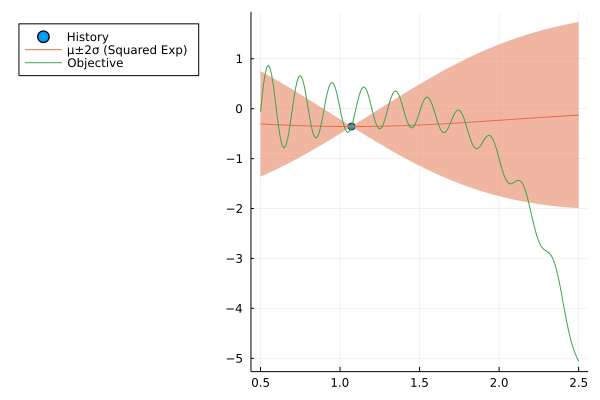

In [10]:
# Visualize surrogate
domain = testfn.bounds[1,1]:.01:testfn.bounds[1,2]
domain = filter(x-> !(x in sur.X), domain)
scatter(sur.X', sur.y, label="History")
plot!(
    domain,
    [sur([x]).μ for x in domain],
    ribbons=2*[sur([x]).σ for x in domain],
    label="μ±2σ ($(name))"
)
plot!(
    domain,
    [testfn.f([x]) for x in domain],
    label="Objective",
    legend=:outertopleft
)

## 3. Construct the acquisition function
Our acquisition functions directly influence our choice of sample location. They can be thought of as query strategies. The most common acquisition functions in the vanilla Bayesian optimization literature are *Probability of Improvement, Expected Improvement, and Upper Confidence Bound*. The derivation of the acquisition functions under the Gaussian process posterior in 1D is analytic and given as follows.
<hr>

#### Probability of Improvement
The probability of improvement (POI) is defined as follows:

$$
POI(x) = \Phi\left( \frac{\mu(x) - f^+ - \xi}{\sigma(x)} \right)
$$

where $f^+$ denotes the best value (maximum) known, $\mu(x)$ is the predictive mean at x, $\sigma(x)$ is the predictive variance, $\xi$ is our exploration parameter, and $\Phi$ is the standard normal cumulative distribution function.
<hr>

#### Expected Improvement
The expected improvement (EI) is defined as follows:

$$
EI(x) = (\mu(x) - f^+ - \xi)\Phi\left( \frac{\mu(x) - f^+ - \xi}{\sigma(x)} \right) +
        \sigma(x)\phi\left(\frac{\mu(x) - f^+ - \xi}{\sigma(x)}\right)
$$

where $\phi$ is the standard normal probability density function.
<hr>

#### Upper Confidence Bound
The upper confidence bound (UCB) is defined as follows:

$$
UCB(x) = \mu(x) + \beta\sigma(x)
$$

where $\beta$ is our exploration parameter.
<hr>

In [11]:
z(μ, σ, f⁺; ξ) = (μ-f⁺-ξ)/σ

function POI(s::RBFsurrogate; ξ=1., tol=1e-6)
    f⁺ = minimum(s.y)
    return function POIx(x::Float64)
        sx = s([x])
        if sx.σ <= tol return 0 end
        
        Φx = cdf(Normal(), z(sx.μ, sx.σ, f⁺; ξ=ξ))
        
        return Φx
    end
end

function EI(s::RBFsurrogate; ξ=1., tol=1e-6)
    f⁺ = minimum(s.y)
    return function EIx(x::Float64)
        sx = s([x])
        if sx.σ <= tol return 0 end

        zx = z(sx.μ, sx.σ, f⁺; ξ=ξ)
        Φx = cdf(Normal(), zx)
        ϕx = pdf(Normal(), zx)
        
        return (zx*sx.σ)*Φx + sx.σ*ϕx
    end
end

function UCB(s::RBFsurrogate; β=1., tol=1e-6)
    return function UCBx(x::Float64)
        sx = s([x])
        if sx.σ <= tol return end
        
        return sx.μ + β*sx.σ
    end
end

function stdize(series)
    smax, smin = maximum(series), minimum(series)
    return [(s-smin)/(smax-smin) for s in series]
end

stdize (generic function with 1 method)

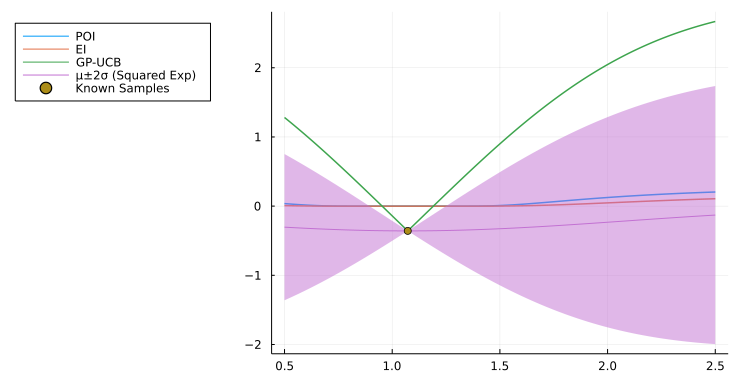

In [12]:
# Plot standardized predictive moments
μs = [sur([x]).μ for x in domain]
scale = maximum(μs)
σs = 2*[sur([x]).σ for x in domain]

# Visualize acquisition functions
POIx = POI(sur).(domain)
# POIx = scale*stdize(POIx)

EIx = EI(sur).(domain)
# EIx = scale*stdize(EIx)

UCBx = UCB(sur; β=3.).(domain)
# UCBx = scale*stdize(UCBx)

# Densely compute acquisition functions
plot(domain, POIx, label="POI", width=1.5)
plot!(domain, EIx, label="EI", width=1.5)
plot!(domain, UCBx, label="GP-UCB", width=1.5, legend=:outertopleft, size=(740,380))
plot!(domain, μs, ribbons=σs, label="μ±2σ ($(name))")
scatter!(sur.X', sur.y, label="Known Samples")

## 4. Optimize the acquisition function
Now that we've constructed our acquisition function, optimizing it directly corresponds to selecting a location that we believe is best, according to the chosen selection criteria. 

In [13]:
xopt = 1.
lowerbound, upperbound = testfn.bounds[1,1:2]
for α in [POI, UCB, EI]
    res = optimize(
        x -> -α(sur)(first(x)),
        lowerbound,
        upperbound
    )
    xopt = Optim.minimizer(res)
    println("Minimizer of $α: $xopt")
end

Minimizer of POI: 2.499999940321925
Minimizer of UCB: 2.499999940321925
Minimizer of EI: 2.499999940321925


## 5. Sample new data at location based on optimization of acquisition function
After solving the interim optimization problem, we then sample from our original expensive process at location $x^{opt}$. Before we sample, let's recall what our current beliefs look like visually.

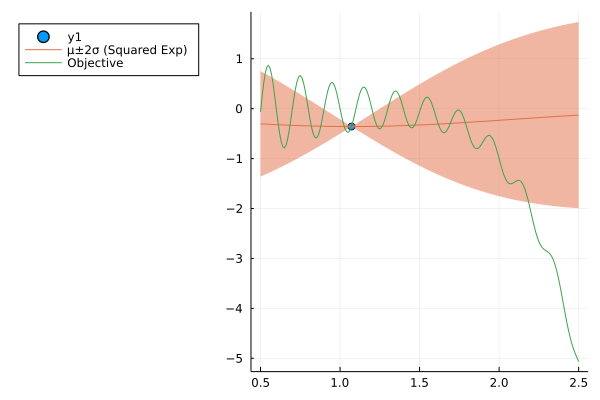

In [14]:
# Visualize surrogate
domain = testfn.bounds[1,1]:.01:testfn.bounds[1,2]
domain = filter(x-> !(x in sur.X), domain)
scatter(sur.X', sur.y)
plot!(
    domain,
    [sur([x]).μ for x in domain],
    ribbons=2*[sur([x]).σ for x in domain],
    label="μ±2σ ($(name))"
)
plot!(
    domain,
    [testfn.f([x]) for x in domain],
    label="Objective",
    legend=:outertopleft
)

In [15]:
# Sample new data at location xopt
xnew, ynew = xopt, testfn.f(xopt)
xnew = reshape([xnew], length(xnew), 1)
Xupdate = hcat(sur.X, xnew)
yupdate = vcat(sur.y, ynew)

usur = fit_surrogate(ψ::RBFfun, Xupdate, yupdate)
θ, usur = optimize_hypers(ψ.θ, kernel, usur.X, usur.y);

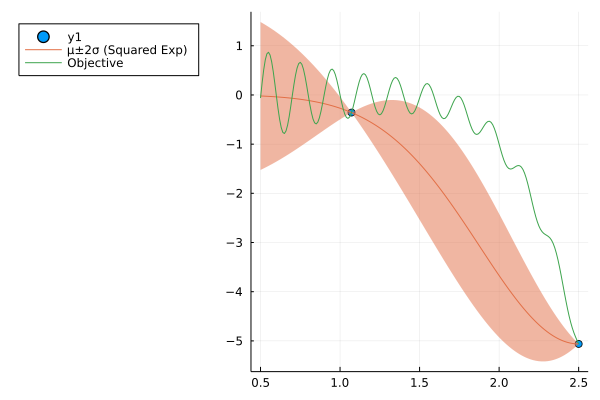

In [16]:
# Visualize surrogate
domain = testfn.bounds[1,1]:.01:testfn.bounds[1,2]
domain = filter(x-> !(x in usur.X), domain)
scatter(usur.X', usur.y)
plot!(
    domain,
    [usur([x]).μ for x in domain],
    ribbons=2*[usur([x]).σ for x in domain],
    label="μ±2σ ($(name))"
)
plot!(
    domain,
    [testfn.f([x]) for x in domain],
    label="Objective",
    legend=:outertopleft
)

## 6. Repeat steps 2-5 until budget is exhausted
Most of the computations have been mapped out, the final portion of Bayesian optimization consist of running this process until we consume our "budget". Our budget can be related to cost, time, clock cycles, etc. For our purposes, we'll assume our budget is in terms of computations; each iteration will cost us one unit of our maximum budget $B$.

### Worth mentioning
It's worth mentioning that Bayesian optimization doesn't always converge to the global optimum, but it gives us a principled way of incorporating our beliefs and known data to guide our sampling strategy. In some scenarios, you may get lucky and do better with random sampling, though this doesn't happen very frequently. It can be shown that simple uniform random sampling exhibits a clustering of points. Consider the following visualization of this phenomenon in the unit square.

You may find it reasonable to dynamically adjust your strategy if you observe the agents tendency to sample in areas that are well-known by encouraging exploration.

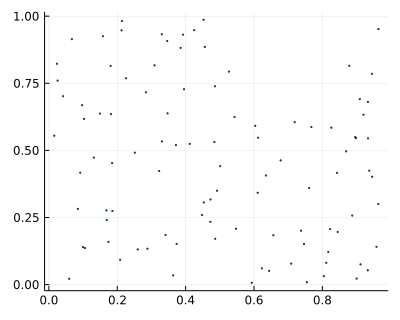

In [17]:
# Animate this process for increasingly larger values of N
N = 100
pairs = rand(2, N)
x, y = pairs[1,:], pairs[2,:]
scatter(x, y, markersize=1., label=nothing, size=(400,320))

In [18]:
BUDGET = 30
s = nothing
tf = nothing
tf_name = nothing
xfinals = []

for (testfn, testfn_name) in test_suite[3:3]
    testfn = negative(testfn)
    tf, tf_name = testfn, testfn_name
    lowerbound, upperbound = testfn.bounds[1,1:2]
    for (kernel, kernel_name) in kernel_suite[2:2]
        # 1. Gather our initial data
        X = randsample(1, testfn.dim, testfn.bounds[1,1], testfn.bounds[1,2])
        y = [testfn.f(X[:,i]) for i in 1:size(X,2)]
        for iter in 1:BUDGET
            # 2. Initialize/update the surrogate model
            θ = [1.]
            ψ = kernel(θ)
            s = fit_surrogate(ψ::RBFfun, X, y)
            θ, s = optimize_hypers(ψ.θ, kernel, s.X, s.y)

            # 3 & 4. Construct and optimize the acquisition function
            res = optimize(x -> -EI(s; ξ=1.)(first(x)), lowerbound, upperbound)
            xopt = Optim.minimizer(res)

            # 5. Sample at new data location from previous optimization
            xnew = reshape([xopt], length(xopt), 1)
            ynew = testfn.f(xnew)

            # 5b. Update design matrix and observation vector
            X = hcat(X, xnew)
            y = vcat(y, ynew)
        end
            
        yfinal, ndx = findmax(s.y)
        xfinal = first(s.X[:,ndx])
        push!(xfinals, xfinal)

    end
end

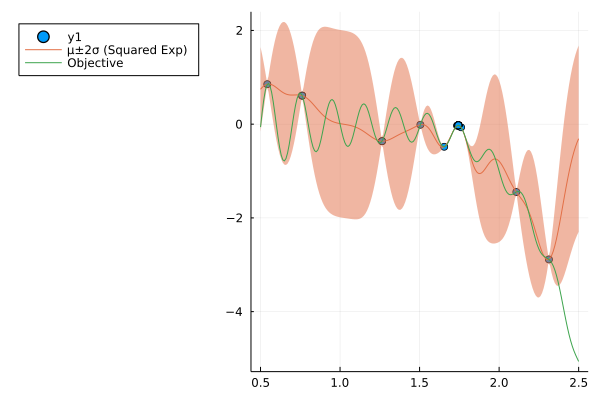

In [19]:
# Visualize surrogate
domain = tf.bounds[1,1]:.01:tf.bounds[1,2]
domain = filter(x-> !(x in s.X), domain)
scatter(s.X', s.y)
plot!(
    domain,
    [s([x]).μ for x in domain],
    ribbons=2*[s([x]).σ for x in domain],
    label="μ±2σ ($(name))"
)
plot!(
    domain,
    [tf.f([x]) for x in domain],
    label="Objective",
    legend=:outertopleft
)

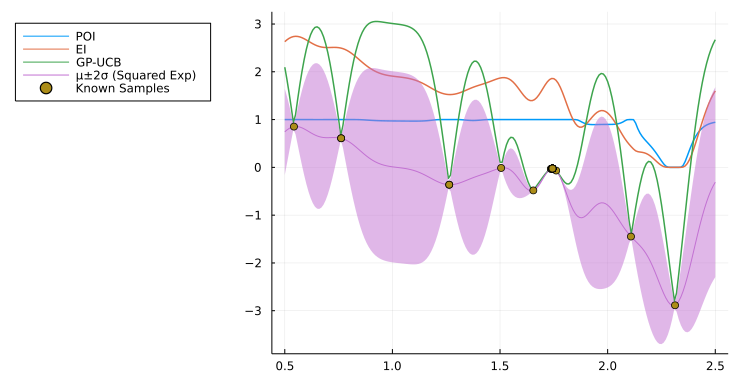

In [20]:
# Plot standardized predictive moments
μs = [s([x]).μ for x in domain]
scale = maximum(μs)
σs = 2*[s([x]).σ for x in domain]

# Visualize acquisition functions
POIx = POI(s).(domain)
# POIx = scale*stdize(POIx)

EIx = EI(s).(domain)
# EIx = scale*stdize(EIx)

UCBx = UCB(s; β=3.).(domain)
# UCBx = scale*stdize(UCBx)

# Densely compute acquisition functions
plot(domain, POIx, label="POI", width=1.5)
plot!(domain, EIx, label="EI", width=1.5)
plot!(domain, UCBx, label="GP-UCB", width=1.5, legend=:outertopleft, size=(740,380))
plot!(domain, μs, ribbons=σs, label="μ±2σ ($(name))")
scatter!(s.X', s.y, label="Known Samples")

## 7. Make final recommendation
Now that we've exhausted our budget, we make our final recommendation.

In [21]:
yfinal, ndx = findmax(s.y)
xfinal = first(s.X[:,ndx])
println("Final recommendation ordered pair (xfinal, yfinal): ($xfinal, $yfinal)")

Final recommendation ordered pair (xfinal, yfinal): (0.5425724725044163, 0.852779894089306)


# References
- Peter Frazier. A Tutorial on Bayesian Optimization
- Gaussian Processes for Machine Learning


### Playground Below Here
Here is a visualization technique that allows you to see the trajectory associated with the optimizer. The x-axis is the iteration count and the y-axis is the location we sample at, given the current iteration. Sometimes we don't converge to the global optimum and we can encourage exploration by dynamically adjusting our acquisition strategy. There are several ways of making the optimization more robust, but we don't explore them in this tutorial. We also haven't gone into detail about the surrogate model; Gaussian processes have been studied fairly well and this tutorial used them without going in-depth about its properties.

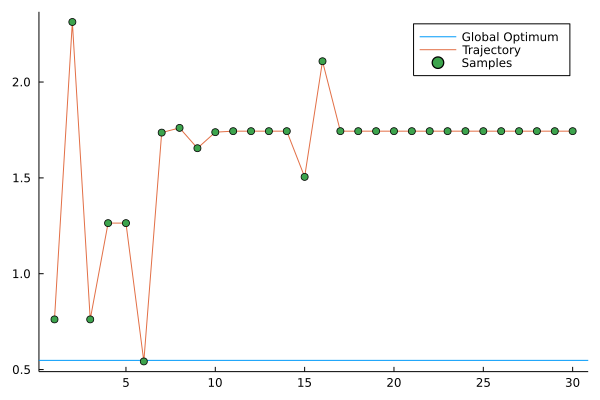

In [23]:
iterations = size(s.X, 2)
plot()
# vline!(1:iterations)
hline!(first(tf.xopt), label="Global Optimum")
plot!(1:iterations, s.X', label="Trajectory")
scatter!(1:iterations, s.X', grid=nothing, label="Samples")